In [1]:
import numpy as np
import matplotlib.pyplot as plt
import finufft
import numpy.fft as fft
from scipy import integrate
import math
import torch

In [8]:
# parameters
n = 100  # number of source points
r = int(0.8/1.024 * n) // 2  # radius of aperture
pad = 2
N = n * pad

pitch = 1e-6
z = 0.005 # 1/(1/25e-3 - 1/1.7) # 
l = N * pitch

lam = 500e-9
k = 2 * np.pi / lam

theta = 5  # incident angle
zo = 1.7  # point source distance
x0, y0 = -np.tan(theta / 180 * np.pi) * zo, 0  # object offset
s0, t0 = np.tan(theta / 180 * np.pi) * z, 0  # image offset

f = 25e-3   # focal

# the source points
x = np.linspace(-l / 2, l / 2, N)
y = np.linspace(-l / 2, l / 2, N)
xx, yy = np.meshgrid(x, y, indexing='ij')

In [9]:
def get_exact_spherical_wave_np(src_point, dest_plane, distance):
    ''' 
    Get the phase shift of the spherical wave from a single point source 
    
    :param src: tuple (x,y), spatial coordinate of the source
    :param dest: tensor [uu,vv], coordinate grid at the destination
    :param distance: scalar tensor, travel distance
    :return: (DxCxUxV) amplitude and phase of the spherical wave
    '''

    x = src_point[0]
    y = src_point[1]
    radius = np.sqrt(distance**2 + (dest_plane[0]-x)**2 + (dest_plane[1]-y)**2)
    phase = k * (radius - distance)

    # normalize the total energy of input light to 1
    amplitude = pupil * distance / lam / radius**2
    amplitude /= np.sqrt(np.sum(amplitude**2, axis=(-2,-1), keepdims=True))
    return amplitude * np.exp(1j * phase)


def get_plane_wave(src_point, dest_plane, distance):
    x = src_point[0]
    y = src_point[1]
    vec = np.array([-x, -y, distance])
    kx, ky, kz = vec / np.sqrt(np.dot(vec, vec))

    # radius = np.sqrt((distance**2 + dest_plane[0]-x)**2 + (dest_plane[1]-y)**2)
    phase = k * (kx * dest_plane[0] + ky * dest_plane[1] + kz)

    # normalize the total energy of input light to 1
    amplitude = pupil * np.ones_like(phase)
    amplitude /= np.sqrt(np.sum(amplitude**2, axis=(-2,-1), keepdims=True))
    return amplitude * np.exp(1j * phase)


def get_lens_phase_shift(f, ap_coords):
    phase = k/2 * (-1/f) * (ap_coords[0]**2 + ap_coords[1]**2)
    return np.exp(1j * phase)

In [10]:
# create input field
# the aperture
c = np.linspace(-N//2, N//2, N)
uu, vv = np.meshgrid(c, c, indexing='ij')
pupil = np.where(uu**2+vv**2<=r**2, 1, 0)

# E1 = pupil * get_plane_wave((xo, yo), np.stack((xx, yy), axis=0), zo)
E1 = pupil * get_exact_spherical_wave_np((x0, y0), np.stack((xx, yy), axis=0), zo) * get_lens_phase_shift(f, np.stack((xx, yy), axis=0))
# plt.figure(figsize=(2,2))
# E1 = get_exact_spherical_wave_np((xo, yo), np.stack((xx, yy), axis=0), zo)
# plt.imshow(np.abs(E1), cmap='gray')

## RS

## Baseline (Shift-BEASM)

max freq: 62.19, interval: 0.63, length: (200, 200)


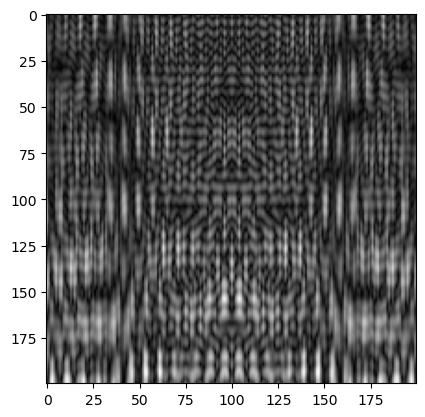

In [11]:
# from shift_BEASM_cpu import BEASM2d
# prop = BEASM2d(z, x, y, lam, 'cpu')
# U = prop(E1)
# plt.imshow(abs(U), cmap='gray')

from shift_BEASM_cpu import shift_BEASM2d
prop = shift_BEASM2d(s0, t0, z, x, y, lam)
U1 = prop(E1)
plt.imshow(np.abs(U1), cmap='gray')

In [ ]:
result1 = np.abs(U1)[..., N//2-r:N//2+r, N//2-r:N//2+r]
plt.imshow(result1, cmap='gray')

## Ours (SVASM)

max freq: 671485.36, interval: 326.12, length: (3051, 3051)


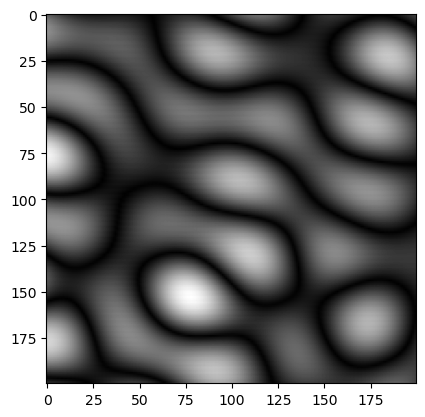

In [12]:
from svASM import AngularSpectrumMethodMM
device = 'cpu' #'cuda:3' # 
prop = AngularSpectrumMethodMM((x0, y0, zo), z, x, y, x, y, lam, device, (s0, t0))
U2 = prop(E1)
plt.imshow(np.abs(U2)[0], cmap='gray')

In [ ]:
result2 = np.abs(U2)[..., N//2-r:N//2+r, N//2-r:N//2+r]
plt.imshow(result2[0], cmap='gray')

## RS (FFT)

In [ ]:
from diffractio.scalar_sources_XY import Scalar_source_XY
from diffractio.scalar_masks_XY import Scalar_mask_XY
u0 = Scalar_source_XY(x, y, lam)
u0.spherical_wave((xo, yo), zo)
t = Scalar_mask_XY(x, y, lam)
t.lens(r0=(0,0), focal=f, radius=r*pitch)
u1 = u0 * t
u2 = u1.RS(z=z, new_field=True, amplification=(2,2))
plt.imshow(abs(u2.u), cmap='gray')

In [ ]:
offxs, offys = int(xs / pitch), int(ys / pitch)
result0 = abs(u2.u)[N//2-offys-r:N//2-offys+r, N//2-offxs-r:N//2-offxs+r]
plt.imshow(result0, cmap='gray')

# Test functions in 1D

## analytical integral 

In [ ]:
j = 0
fun = lambda xn : 1/2/np.pi * z/np.sqrt((X[j]-xn)**2+z**2) * (1./np.sqrt((X[j]-xn)**2+z**2)-1j*k) * np.exp(1j*k*np.sqrt((X[j]-xn)**2+z**2)) / np.sqrt((X[j]-xn)**2+z**2)
fun(0)

In [ ]:
def complex_int(function, a, b):
    func_real = lambda x: function(x).real
    func_imag = lambda x: function(x).imag
    result_real = integrate.quad(func_real, a, b)[0]
    result_imag = integrate.quad(func_imag, a, b)[0]
    return result_real + 1j * result_imag

In [ ]:
X = np.linspace(-l/4, l/4 - pitch, N//2, dtype=np.double)
uu = []
for j in range(N//2):
      fun = lambda xn : 1/2/np.pi * z/np.sqrt((X[j]-xn)**2+z**2) * (1./np.sqrt((X[j]-xn)**2+z**2)-1j*k) * np.exp(1j*k*np.sqrt((X[j]-xn)**2+z**2)) / np.sqrt((X[j]-xn)**2+z**2)
      uu.append(complex_int(fun, -(r-1) * pitch, r * pitch))

uu = np.array(uu)
uu = uu / max(abs(uu))
phase_rsi = np.angle(uu)
amplitude_rsi = np.abs(uu)
plt.plot(X, amplitude_rsi)

## Impulse Response

In [ ]:
R = np.sqrt(x**2 + z**2)
kernel = 1 / 2 / np.pi * z / R * (1 / R - 1j * k) * np.exp(1j * k * R) / R
t_FT = fft.fftshift(fft.fft(fft.fftshift(c)))
kernel_FT = fft.fftshift(fft.fft(fft.fftshift(kernel)))
t_1 = fft.ifftshift(fft.ifft(fft.ifftshift(kernel_FT * t_FT)))
t_1  = t_1 / max(abs(t_1))
t_1 = t_1[N//2 - N//4 + 1 : N//2 + N//4 + 1]
plt.plot(x[N//2 - N//4 + 1 : N//2 + N//4 + 1], abs(t_1))

## BLASM

In [ ]:
fc = N * pitch / lam / z / 2  # f_limit
H = np.exp(1j * k * z * np.sqrt(1 - (s * lam)**2))
H[abs(s) > fc] = 0
t_FT = fft.fftshift(fft.fft(fft.fftshift(c)))
t_2 = fft.ifftshift(fft.ifft(fft.ifftshift(H * t_FT)))
t_2  = t_2 / max(abs(t_2))
t_2 = t_2[N//2 - N//4 + 1 : N//2 + N//4]
phase_asm_li = np.angle(t_2)
amplitude_asm_li = np.abs(t_2)
plt.plot(x[N//2 - N//4 + 1 : N//2 + N//4 + 1], amplitude_asm_li)

## BEASM

In [ ]:
# number of source points
n = 1024
r = n // 4
pad = 2
N = n * pad

pitch = 1e-6
z = 3  #
l = N * pitch

lam = 500e-6
k = 2 * np.pi / lam

# number of target points
M = N

# the source points
x = np.linspace(-l / 2, l / 2, N)

# the target points
s = np.linspace(-1 / 2 / pitch, 1 / 2 / pitch - 1 / l, M)

In [ ]:
iflag = -1
eps = 1e-12
K = N / 2 / np.max(np.abs(s))
fcn = 1 / 2 * np.sqrt(N / lam / z)  # f_extend
ss = fcn / np.max(np.abs(s))
zc = N * pitch**2 / lam
if z < zc:
    fxn = s
else:
    fxn = s * (ss - 0.0)
H = np.exp(1j * k * (z * np.sqrt(1 - (fxn * lam)**2)))

c = pupil[N//2, :] + 1j * 0
t_asmNUFT = finufft.nufft1d3(x / np.max(np.abs(x)) * np.pi, c, fxn * K, isign=iflag, eps=eps)
t_3 = finufft.nufft1d3(x / (np.max(np.abs(x))) * np.pi, H * t_asmNUFT, fxn * K, isign=-iflag, eps=eps)

t_3 = t_3 / np.max(np.abs(t_3))
t_3 = t_3[N//2 - N//4 + 1 : N // 2 + N // 4 + 1]
phase_asm_ex = np.angle(t_3)
amplitude_asm_ex = np.abs(t_3)
plt.plot(x[N//2 - N//4 + 1 : N // 2 + N // 4 + 1], amplitude_asm_ex)